In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.utils import resample

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_auc_score, roc_curve

import imblearn.over_sampling



In [2]:
df_behavior = pd.read_csv('envior-USA.csv')
df_health = pd.read_csv('health-USA.csv')
df_big2 = pd.read_csv('USA-data-categorical.csv')
df_big = pd.read_csv('compact-USA.csv')


In [3]:
df_big = pd.get_dummies(df_big, columns=['household_size2'])

In [4]:
my_list = df_big.columns.values.tolist()

print (my_list)

['weight', 'age', 'COVID-19 Status_Yes, and I tested positive', 'Contact w/ COVID_Yes', 'Travel_Yes', 'Facemask Use_Not at all', 'Soap Use_Not at all', 'Avoided shops_Not at all', 'Avoided public transport?_Not at all', 'Avoided working from home?_Not at all', 'gender_Female', 'gender_Male', 'employment_status_Full time employment', 'employment_status_Full time student', 'employment_status_Not working', 'employment_status_Other', 'employment_status_Part time employment', 'employment_status_Retired', 'guests_Not at all', 'small_events_Not at all', 'medium_events_Not at all', 'large_events_Not at all', 'employment_status_Unemployed', 'Preexisting Condition Score', 'events_score', 'household_size2_1', 'household_size2_2', 'household_size2_3', 'household_size2_4', 'household_size2_5', 'household_size2_6', 'household_size2_7']


In [113]:
df_big = df_big.drop(['guests_Not at all', 'small_events_Not at all', 'medium_events_Not at all', 'large_events_Not at all'], axis=1)

In [5]:
X = df_big.drop(['COVID-19 Status_Yes, and I tested positive'], axis=1)
y = df_big['COVID-19 Status_Yes, and I tested positive']

In [6]:
counts = y.value_counts()


In [7]:
counts

0    31844
1      216
Name: COVID-19 Status_Yes, and I tested positive, dtype: int64

Text(0, 0.5, 'Number of Cases')

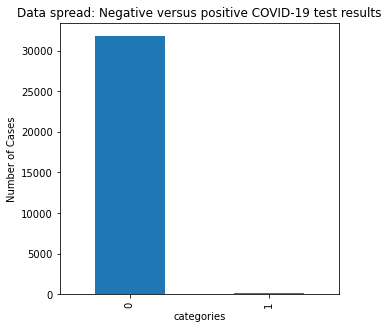

In [8]:
counts.plot.bar(figsize=(5, 5))
plt.title('Data spread: Negative versus positive COVID-19 test results')
plt.xlabel('categories')
plt.ylabel('Number of Cases')

In [9]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(25,'Score'))  #print 10 best features

                                     Specs        Score
2                     Contact w/ COVID_Yes  7544.400908
3                               Travel_Yes  5443.807602
1                                      age  1076.640111
23                            events_score    86.301873
22             Preexisting Condition Score    53.115078
8    Avoided working from home?_Not at all    31.564608
4                  Facemask Use_Not at all    30.931239
18                 small_events_Not at all    29.308516
16               employment_status_Retired    25.326829
11  employment_status_Full time employment    25.287527
19                medium_events_Not at all    22.723850
7     Avoided public transport?_Not at all    21.810898
10                             gender_Male    20.119440
30                       household_size2_7    19.812879
17                       guests_Not at all    18.624629
6                 Avoided shops_Not at all    18.560875
9                            gender_Female    18

In [ ]:
X

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state=42)

In [ ]:
smote = imblearn.over_sampling.SMOTE(random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_resample(X_train, y_train)

lr_smote = LogisticRegression(solver='liblinear') 
lr_smote.fit(X_tr_smote, y_tr_smote)
logit_pred = lr_smote.predict(X_test)

print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr_smote.predict(X_test)), roc_auc_score(y_test, lr_smote.predict_proba(X_test)[:,1])))
print("Recall Score: {:6.2f}%".format(100*recall_score(y_test, lr_smote.predict(X_test))))
print("logit confusion matrix: \n\n", confusion_matrix(y_test, lr_smote.predict(X_test)))


In [11]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

In [12]:
# separate minority and majority classes
not_COVID = X[X['COVID-19 Status_Yes, and I tested positive']==0]
COVID = X[X['COVID-19 Status_Yes, and I tested positive']==1]

In [13]:
# upsample minority
fraud_upsampled = resample(COVID,
                          replace=True, # sample with replacement
                          n_samples=len(not_COVID), # match number in majority class
                          random_state=27) # reproducible results

In [14]:
# combine majority and upsampled minority
upsampled = pd.concat([not_COVID, fraud_upsampled])

In [15]:
# check new class counts
upsampled['COVID-19 Status_Yes, and I tested positive'].value_counts()


0    25473
1    25473
Name: COVID-19 Status_Yes, and I tested positive, dtype: int64

In [16]:
# trying logistic regression again with the balanced dataset
y_train = upsampled['COVID-19 Status_Yes, and I tested positive']
X_train = upsampled.drop('COVID-19 Status_Yes, and I tested positive', axis=1)

In [17]:
print("COVID-19 Data Set Results w/ oversampling")

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("\nThe score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))
print("kNN confusion matrix:\n\n", confusion_matrix(y_test, knn.predict(X_test)))
knn_pred = knn.predict(X_test)
print("F1 Score: {:6.2f}%".format(100*f1_score(y_test, knn_pred)))
print("Recall Score: {:6.2f}%".format(100*recall_score(y_test, knn_pred)))
print("ROC AUC score =", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))

logit = LogisticRegression(C = 1)
logit.fit(X_train, y_train)
print("\n\nThe score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))
print("logit confusion matrix: \n\n", confusion_matrix(y_test, logit.predict(X_test)))
logit_pred = logit.predict(X_test)
print("F1 Score: {:6.2f}%".format(100*f1_score(y_test, logit_pred)))
print("Recall Score: {:6.2f}%".format(100*recall_score(y_test, logit_pred)))
print("ROC AUC score = ", roc_auc_score(y_test, logit.predict_proba(X_test)[:,1]))

decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train)
print("\n\nThe score for decision tree regression is")
print("Training: {:6.2f}%".format(100*decisiontree.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*decisiontree.score(X_test, y_test)))
print("decision tree matrix: \n\n", confusion_matrix(y_test, decisiontree.predict(X_test)))
decisiontree_pred = decisiontree.predict(X_test)
print("F1 Score: {:6.2f}%".format(100*f1_score(y_test, decisiontree_pred)))
print("Recall Score: {:6.2f}%".format(100*recall_score(y_test, decisiontree_pred)))
print("ROC AUC score = ", roc_auc_score(y_test, decisiontree.predict_proba(X_test)[:,1]))


randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(X_train, y_train)
print("\n\nThe score for random forest regression is")
print("Training: {:6.2f}%".format(100*randomforest.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*randomforest.score(X_test, y_test)))
print("random forest matrix: \n\n", confusion_matrix(y_test, randomforest.predict(X_test)))
randomforest_pred = randomforest.predict(X_test)
print("F1 Score: {:6.2f}%".format(100*f1_score(y_test, randomforest_pred)))
print("Recall Score: {:6.2f}%".format(100*recall_score(y_test, randomforest_pred)))
print("ROC AUC score = ", roc_auc_score(y_test, randomforest.predict_proba(X_test)[:,1]))


COVID-19 Data Set Results w/ oversampling

The score for kNN is
Training:  99.65%
Test set:  98.57%
kNN confusion matrix:

 [[6311   60]
 [  32    9]]
F1 Score:  16.36%
Recall Score:  21.95%
ROC AUC score = 0.6520035526834629


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(




The score for logistic regression is
Training:  88.08%
Test set:  91.70%
logit confusion matrix: 

 [[5850  521]
 [  11   30]]
F1 Score:  10.14%
Recall Score:  73.17%
ROC AUC score =  0.903909100305883


The score for decision tree regression is
Training: 100.00%
Test set:  99.13%
decision tree matrix: 

 [[6347   24]
 [  32    9]]
F1 Score:  24.32%
Recall Score:  21.95%
ROC AUC score =  0.6078897902461995


The score for random forest regression is
Training: 100.00%
Test set:  99.39%
random forest matrix: 

 [[6359   12]
 [  27   14]]
F1 Score:  41.79%
Recall Score:  34.15%
ROC AUC score =  0.861282641236395


In [ ]:
X

In [ ]:
import math

In [18]:

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logit.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

In [19]:
mask = abs(importances['Importance']) > 0.25

In [20]:
importances2 = importances[mask]

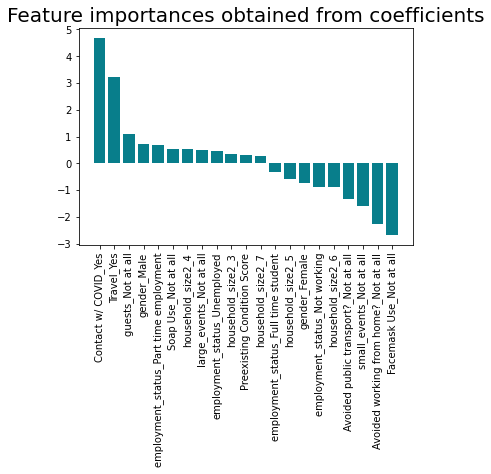

In [21]:
plt.bar(x=importances2['Attribute'], height=importances2['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()